In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
from test import *
import random
import matplotlib.pyplot as plt

In [2]:
def add_normal_noise(dataset, sigma):
    return [(d[0], d[1] + random.gauss(0, sigma)) for d in dataset]

def plot_dataset(data, hline=None, reg=None):
    x = [d[0] for d in data]
    y = [d[1] for d in data]
    plt.figure(figsize=(20,20))
    plt.subplot(2,1,1)
    plt.plot(x, y, 'o', color='blue')
    if hline:
        plt.axhline(y=hline, color='red', linestyle='-')
    if reg:
        new_y = [reg.predict(d[0]) for d in sorted(dataset)]
        new_x = [d[0] for d in sorted(dataset)]
        plt.plot(new_x, new_y, '-', color='red')
    axes = plt.gca()
    axes.set_ylim(0)
    plt.show()

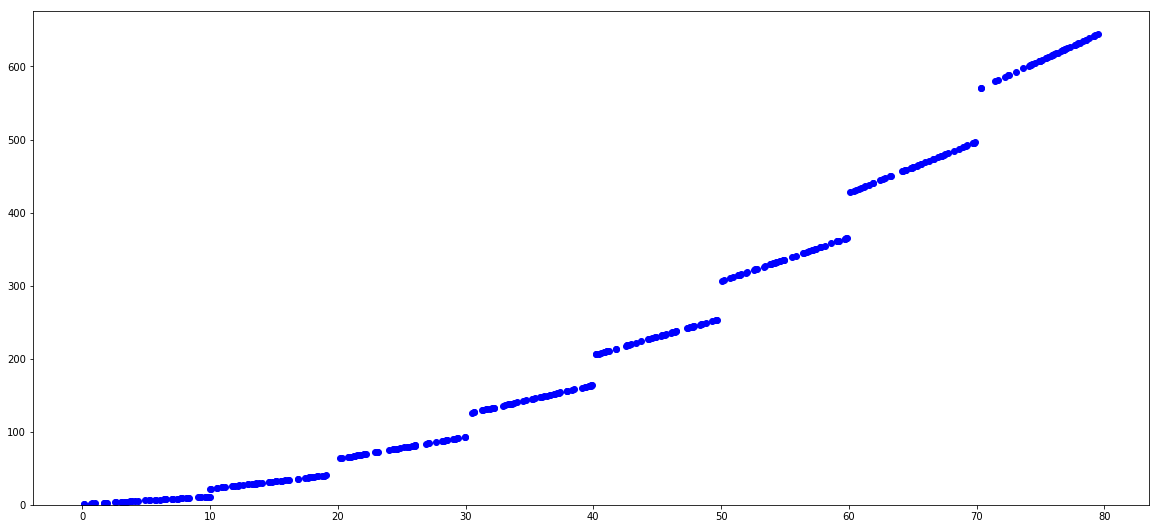

In [3]:
random.seed(27)
all_datasets = [generate_dataset(intercept=i, coeff=i, size=50, min_x=(i-1)*10, max_x=i*10, cls=float) for i in range(1, 9)]
dataset = sum(all_datasets, [])
plot_dataset(dataset)

# Float

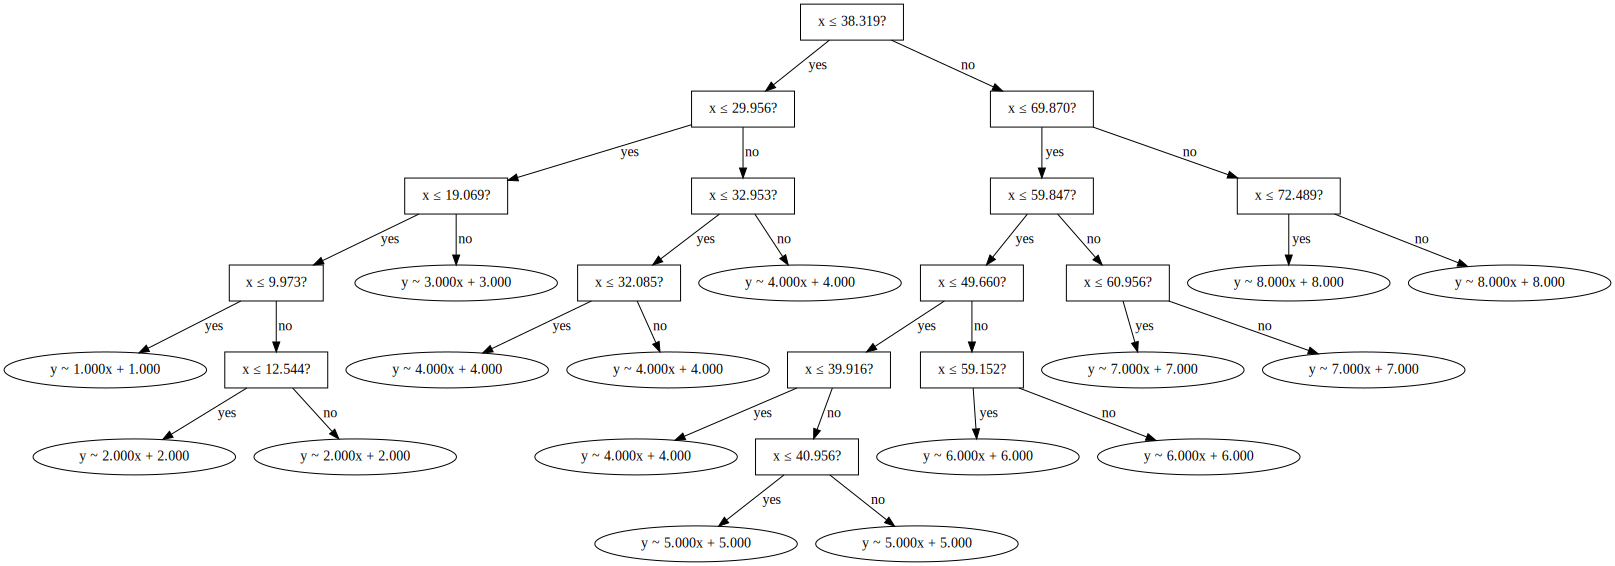

In [4]:
reg = compute_regression(dataset)
reg.to_graphviz()

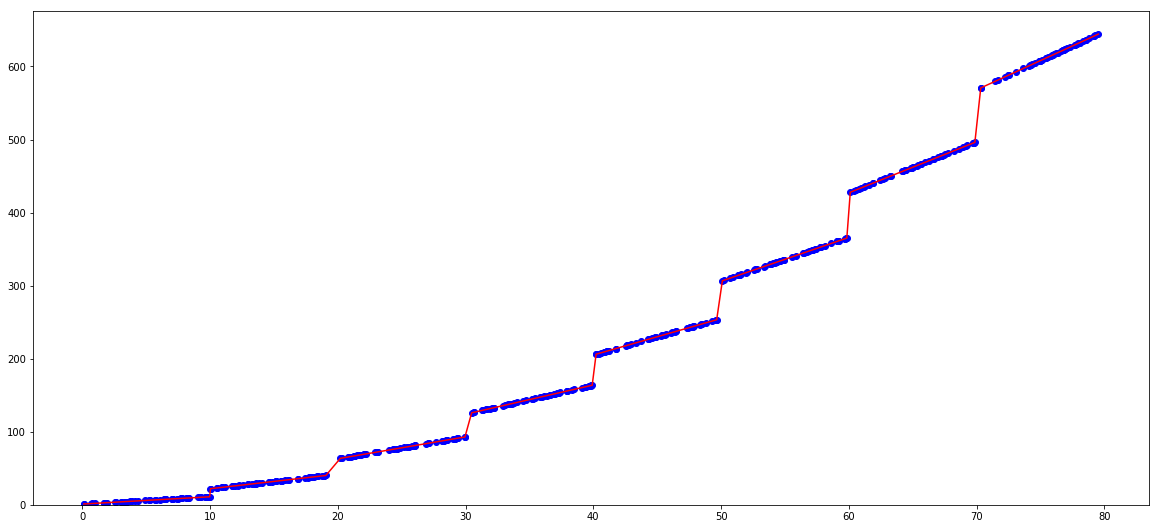

In [5]:
plot_dataset(dataset, reg=reg)

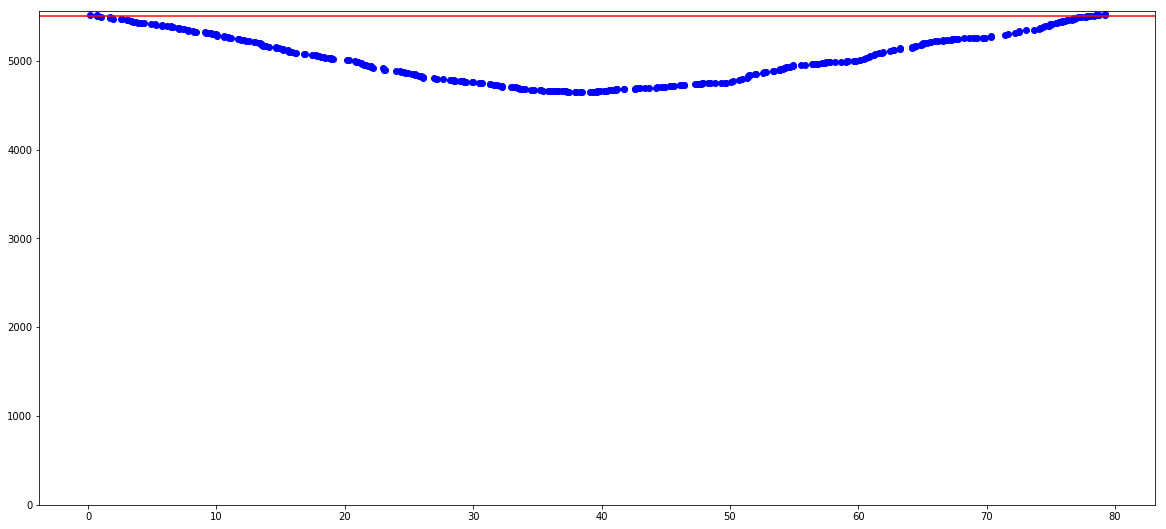

In [6]:
plot_dataset(reg.errors.split, reg.errors.nosplit)

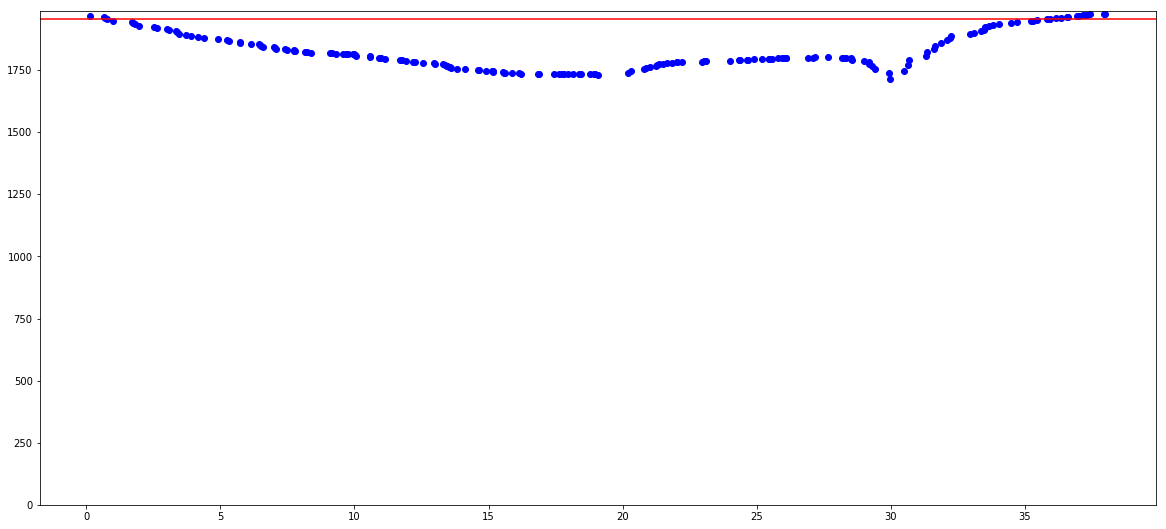

In [7]:
plot_dataset(reg.left.errors.split, reg.left.errors.nosplit)

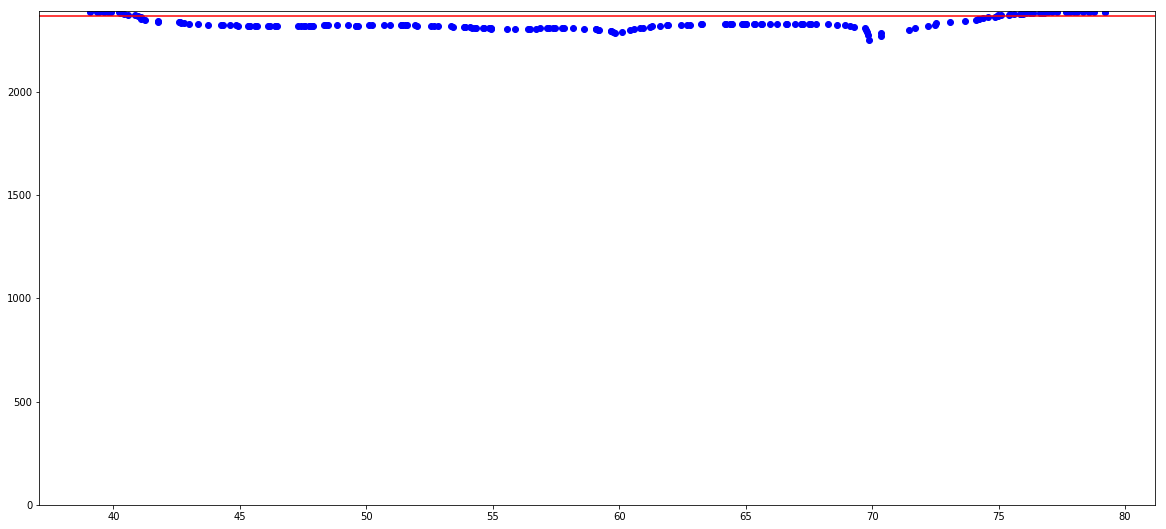

In [8]:
plot_dataset(reg.right.errors.split, reg.right.errors.nosplit)

So we have too much breakpoints. Worse: the "wrong" breakpoints are not even near the leaves, the root itself is wrong. This seems to be a counter-example for the greedy approach (if this is not just a bug in the code). The dynamic programming approach is maybe too expensive.

The current apprpoach I use to simplify nodes can only merge sibling leaves, so it would not work in that case, we need a more general approach. Maybe flatten the tree?

In [9]:
x = reg.right.left.left.right
x

x ≤ 59.152?
    └──y ~ 6.000x + 6.000
    └──y ~ 6.000x + 6.000

In [10]:
import math
def bic(rss, n, k):
    return math.log(n)*k + n*math.log(rss)
y = x.left + x.right
print('### RSS ###')
print(x.RSS, y.RSS, x.RSS/y.RSS)
print(x.compute_RSS(), y.compute_RSS(), x.compute_RSS()/y.compute_RSS())
print(x.compute_statsmodels_RSS(), y.compute_statsmodels_RSS(), x.compute_statsmodels_RSS()/y.compute_statsmodels_RSS())
print()
print('### BIC ###')
print(x.BIC, y.BIC)
bicx = bic(x.compute_RSS(), len(x), x.nb_params)
bicy = bic(y.compute_RSS(), len(y), y.nb_params)
print(bicx, bicy)
bicx = bic(x.compute_statsmodels_RSS(), len(x), x.nb_params)
bicy = bic(y.compute_statsmodels_RSS(), len(y), y.nb_params)
print(bicx, bicy)

### RSS ###
6.984919309616089e-10 1.862645149230957e-09 0.375
5.661017317159783e-24 9.693522803355793e-26 58.4
5.018304443554616e-22 2.5849394142282115e-24 194.13625

### BIC ###
-1026.72071342451 -993.3273427956364
-2649.037769850946 -2868.051656364367
-2424.8048354353677 -2703.8809390640786


In [11]:
print(list(x.left))
print()
print(list(x.right))

[(50.10432792043062, 306.6259675225837), (50.2127987375069, 307.27679242504144), (50.70099868798211, 310.2059921278926), (50.93715661028447, 311.6229396617068), (51.35538861640969, 314.13233169845813), (51.3969910080163, 314.3819460480978), (51.42066373657674, 314.5239824194605), (51.51247183446335, 315.0748310067801), (51.60191550126913, 315.6114930076148), (51.927541105078085, 317.5652466304685), (52.001235454615205, 318.00741272769125), (52.54391867708368, 321.26351206250206), (52.68044235813265, 322.0826541487959), (52.82826851986166, 322.96961111916994), (53.33432281456202, 326.0059368873721), (53.41113510987959, 326.46681065927754), (53.85029129567566, 329.10174777405393), (53.894553730775925, 329.36732238465555), (53.922536212986664, 329.53521727791997), (54.103295765964006, 330.61977459578407), (54.18893106492293, 331.1335863895376), (54.309610102339995, 331.85766061403996), (54.35725613423829, 332.14353680542973), (54.60797187203762, 333.6478312322257), (54.65072209668074, 333

Let's reconstruct this node from scratch with the data. If the computations were stable, we would find similar results.

In [12]:
left =  [(50.10432792043062, 306.6259675225837), (50.2127987375069, 307.27679242504144), (50.70099868798211, 310.2059921278926), (50.93715661028447, 311.6229396617068), (51.35538861640969, 314.13233169845813), (51.3969910080163, 314.3819460480978), (51.42066373657674, 314.5239824194605), (51.51247183446335, 315.0748310067801), (51.60191550126913, 315.6114930076148), (51.927541105078085, 317.5652466304685), (52.001235454615205, 318.00741272769125), (52.54391867708368, 321.26351206250206), (52.68044235813265, 322.0826541487959), (52.82826851986166, 322.96961111916994), (53.33432281456202, 326.0059368873721), (53.41113510987959, 326.46681065927754), (53.85029129567566, 329.10174777405393), (53.894553730775925, 329.36732238465555), (53.922536212986664, 329.53521727791997), (54.103295765964006, 330.61977459578407), (54.18893106492293, 331.1335863895376), (54.309610102339995, 331.85766061403996), (54.35725613423829, 332.14353680542973), (54.60797187203762, 333.6478312322257), (54.65072209668074, 333.90433258008443), (54.83706428730051, 335.02238572380304), (54.92409628972678, 335.5445777383607), (54.941645351451186, 335.6498721087071), (55.57225868216078, 339.43355209296465), (55.8642371835889, 341.1854231015334), (56.390254175083754, 344.3415250505025), (56.48386263728011, 344.90317582368067), (56.714356899080215, 346.2861413944813), (56.869465070212556, 347.21679042127533), (57.13933508749722, 348.83601052498335), (57.21712685641588, 349.30276113849527), (57.38075120289151, 350.2845072173491), (57.45593012713931, 350.73558076283587), (57.72329186963587, 352.3397512178152), (57.80645647556781, 352.8387388534069), (58.1533329779629, 354.9199978677774), (58.625322287598365, 357.7519337255902), (59.0725332403448, 360.4351994420688), (59.100592174317754, 360.60355304590655), (59.15218088924749, 360.91308533548494)]
right = [(59.84728451334123, 365.08370708004736), (59.76511385949758, 364.5906831569855), (59.68896037746818, 364.1337622648091), (59.687430879527966, 364.1245852771678), (59.20174955999306, 361.21049735995837)]
x = Node(
    Leaf([d[0] for d in left] , [d[1] for d in left] , 'BIC'),
    Leaf([d[0] for d in right], [d[1] for d in right], 'BIC'),
    'BIC'
)
y = x.left + x.right
print('### RSS ###')
print(x.RSS, y.RSS, x.RSS/y.RSS)
print(x.compute_RSS(), y.compute_RSS(), x.compute_RSS()/y.compute_RSS())
print(x.compute_statsmodels_RSS(), y.compute_statsmodels_RSS(), x.compute_statsmodels_RSS()/y.compute_statsmodels_RSS())
print()
print('### BIC ###')
print(x.BIC, y.BIC)
bicx = bic(x.compute_RSS(), len(x), x.nb_params)
bicy = bic(y.compute_RSS(), len(y), y.nb_params)
print(bicx, bicy)
bicx = bic(x.compute_statsmodels_RSS(), len(x), x.nb_params)
bicy = bic(y.compute_statsmodels_RSS(), len(y), y.nb_params)
print(bicx, bicy)

### RSS ###
-2.6775524020195007e-09 1.862645149230957e-09 -1.4375
9.370405376577267e-26 9.693522803355793e-26 0.9666666666666667
5.018304443554616e-22 2.5849394142282115e-24 194.13625

### BIC ###
-37194.61943503106 -993.3273427956364
-2854.0986419264386 -2868.051656364367
-2424.8048354353677 -2703.8809390640786


Great differences, we even have a negative RSS, which is absurd!

# Decimal

In [13]:
from decimal import Decimal
dataset_decimal = [(Decimal(x), Decimal(y)) for x, y in dataset]

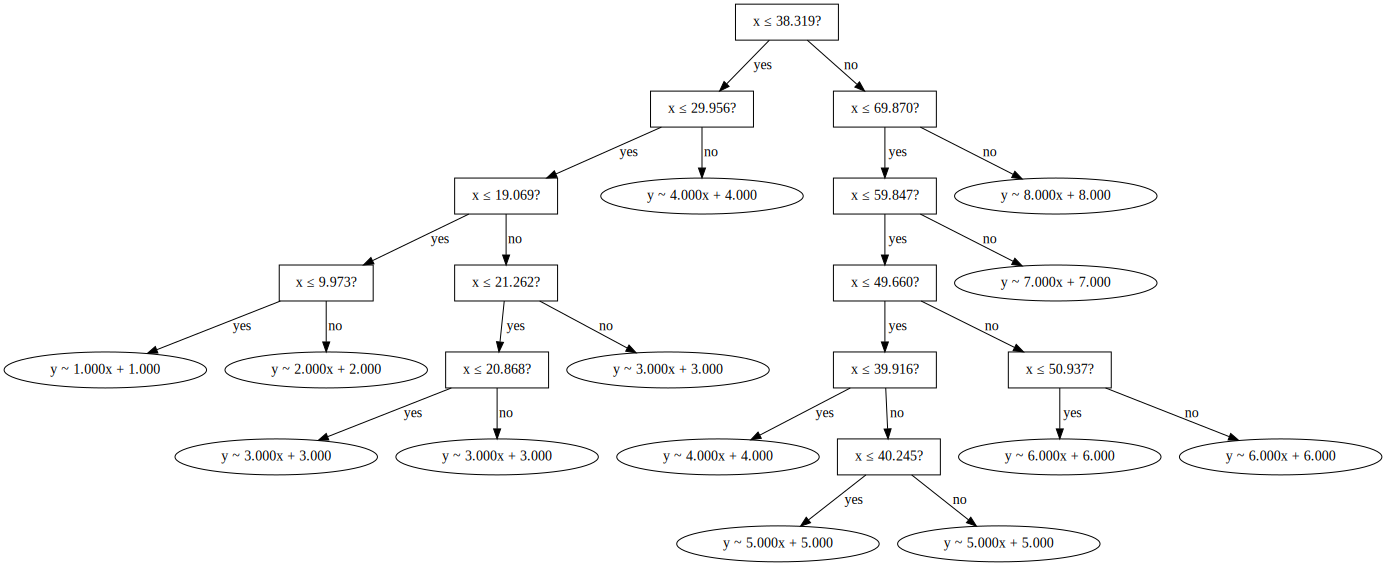

In [14]:
reg = compute_regression(dataset_decimal)
reg.to_graphviz()

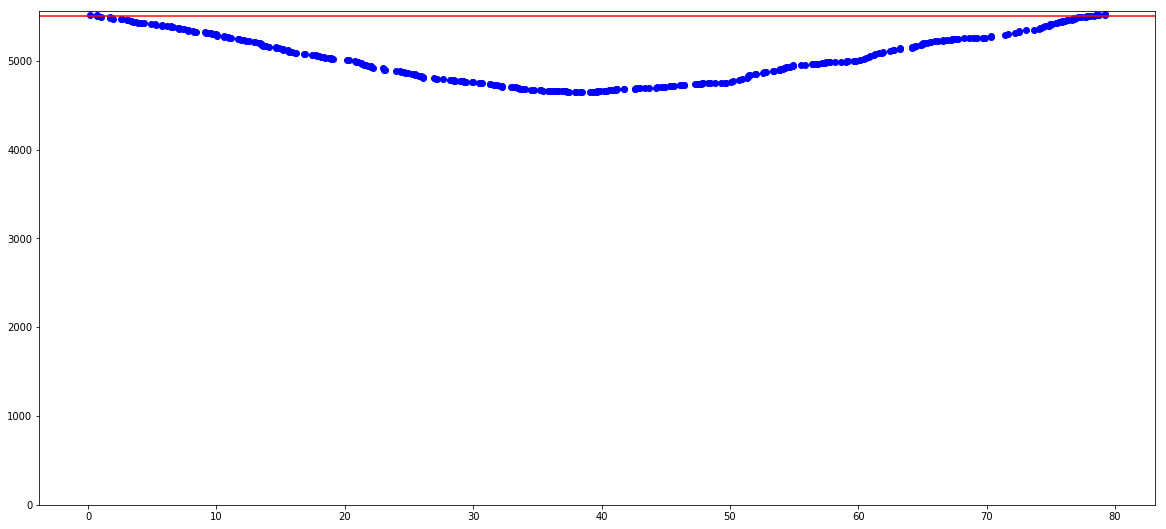

In [15]:
plot_dataset(reg.errors.split, reg.errors.nosplit)

In [16]:
x = reg.right.left.left.right
x

x ≤ 50.937?
    └──y ~ 6.000x + 6.000
    └──y ~ 6.000x + 6.000

In [17]:
y = x.left + x.right
print('### RSS ###')
print(x.RSS, y.RSS, x.RSS/y.RSS)
print(x.compute_RSS(), y.compute_RSS(), x.compute_RSS()/y.compute_RSS())
print()
print('### BIC ###')
print(x.BIC, y.BIC)
bicx = bic(x.compute_RSS(), len(x), x.nb_params)
bicy = bic(y.compute_RSS(), len(y), y.nb_params)
print(bicx, bicy)

### RSS ###
-6E-22 -2E-21 0.3
1.428839359205971753599866833E-26 1.512346039735667064499060531E-26 0.9447833509424265825874696890

### BIC ###
-37194.61943503106609329503366 -37210.26752705277867752950867
-2948.1333359643954 -2960.9414461844044
